In [ ]:
## start a tensorflow session
from pylab import *
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
tf.reset_default_graph()
sess = tf.InteractiveSession()
g = tf.Graph().as_default()
DTYPE = tf.float32
EPS = 1e-9

print( tf.__version__)

In [ ]:
from tensorflow import control_dependencies as con_deps

def assert_close( x, y, rtol=EPS, atol=None ):        
    rtol = tf.cast( rtol, dtype=x.dtype)
    if atol:
        atol = tf.cast( atol, dtype=x.dtype)
    abs_err = tf.reduce_sum( tf.abs( x - y ) ) 
    rel_err = abs_err / tf.reduce_sum( tf.abs( y) )
    test = tf.assert_less_equal( rel_err, rtol, message='relative error too large') if not atol\
        else tf.assert_less_equal( abs_err, atol, message='absolute error too large') 
    with con_deps( [test]):
        return tf.Print( rel_err, [rel_err, abs_err], 'assert_close::' )
    
def project_simplex( x, r=1.0 ):
    ''' 
    Project a vector x onto the r-simplex
    See algorihtm by Duchi 2008 (https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf)
    '''
    assert len( x.shape ) == 1, 'non vector projection not supported'
    D = x.shape[0]
    r = tf.cast( r, dtype=x.dtype)
    with tf.name_scope( 'project_simplex'):
        def _proj_in( ):
            '''project inward'''
            # sort descending - do this is in full precision otherwise errors accumulate too fast
            xs = tf.cast( tf.nn.top_k( x, k=D)[0], dtype=tf.float64 )
            xsc = tf.cumsum( xs )
            # compute threshold after which corresponding coord becomes inactive
            theta = (xsc - r) / tf.cumsum( tf.ones_like( x, dtype=tf.float64 ) )
            # handle the case where the threshold does not dro below all elements and the whole vector 
            # needs to be shrunk
            thresh = tf.minimum( tf.reduce_min( tf.where( (xs-theta) <= 0) ), D.value - 1)
            rho = theta[thresh]
            return tf.maximum( x - tf.cast( rho, dtype=x.dtype), 0.0 )
        def _proj_out():
            '''project outward'''
            rho = ( r - tf.reduce_sum( x)) / D.value            
            return x + rho        
        px = tf.cond( tf.reduce_sum(x) > r, true_fn=_proj_in, false_fn=_proj_out, name='proj_switch' )
        with con_deps( [assert_close(tf.reduce_sum(px), r, rtol=1e-2)]):            
            return tf.Print( px, [tf.reduce_sum(px), tf.reduce_sum(x)], 'project_simplex:: px, x = ')

# test project_simplex
x = tf.range( 10 ) / 100    
project_simplex( x ).eval()

def TV( x, name='TV'):
    '''total variation penalty'''
    assert len( x.shape ) == 1, 'non vector TV not supported {}'.format( x.shape )
    return tf.norm( 
        tf.nn.conv1d(
            tf.reshape( x, [1, -1, 1] ),
                filters=tf.reshape( tf.constant([-1.0, 1.0, 0], dtype=x.dtype), [-1,1,1], name='first_diff'),
                stride=1, padding='SAME'
            ), 
        1, name=name 
    )

def downsample( x, factor ):
    '''
    Causal averaging followed by downsampling
    
    Parameters;
    ----------
    x: T tensor of time-series
    factor; downsampling factor    
    '''
    return tf.squeeze( tf.nn.avg_pool( tf.reshape( x, [1, -1, 1, 1]), ksize=[1, factor, 1, 1], strides=[1, factor, 1, 1], padding='VALID' ) )


# the EG algorithsm.0
def eg( loss, w, shift_rate=tf.constant(0, dtype=DTYPE), eta_0=None, max_its=100, tol=tf.constant(1e-16), step_rule='sqrt' ):
    
    '''  
    do batch eg on the given loss tensor. w are the simplex weights
    
    Parameters
    ----------
    loss: A function with returns losses
    w: the parameter tensor
        
    Returns
    -----------
    k: tf.Tensor of iteration counts    
    w: tf.Tensor of final weights
    rel_chg: tf.Tensor of relative change
    weights: tf.TensorArray of weights
    losses: TensorArray of losss
    rel_changes: TensorArray of relative changes    
    etas: tf.TensorArray of learning raters
    max grads: tf.TensorArray of max gradients
    '''    
    
    def _eg_step( k, w, rel_chng, weights, changes, losses, etas, max_grads ):
        '''
        eg step with no sleeping expert correction
        # for sleeping expert do this 
        
        # awake_sum = tf.reduce_sum( tf.where( nan_mask, tf.zeros_like(w), w) )
        # w_s = tf.where( nan_mask, tf.zeros_like(w), tf.divide( w, awake_sum ) )
        
        # theoretical optimal eta = sqrt( 2 log N / K ) / G_inf
        '''        
        l = loss(w)
        grad = tf.gradients( l, w )[0]
        nan_mask = tf.is_nan( grad )        
        grad = tf.where( nan_mask, tf.zeros_like(grad, dtype=DTYPE), grad )
        # find the new max gradient
        G_inf = tf.maximum( max_grads.read(k), tf.reduce_max( tf.abs( grad ) ) )        
        # pre-condition
        grad = grad - tf.reduce_min( grad )             
        if step_rule == 'constant':
            eta = eta_0 / G_inf
        elif step_rule == 'sqrt':
            eta = eta_0 / G_inf / tf.sqrt( 1 +  tf.cast( k, dtype=DTYPE) )
        elif step_rule == 'inv':
            eta = eta_0 / G_inf / ( 1 + tf.cast( k, dtype=DTYPE) )
        w_n = w * tf.exp( -eta  * grad )
        w_n = w_n / tf.reduce_sum( w_n ) * (1 - shift_rate) + shift_rate     
        rel_chng = tf.reduce_sum( tf.abs( w_n - w / tf.reduce_sum( tf.abs( w ) ) ) ) 
        k = k + 1
        # save the updates
        etas = etas.write( k, eta )
        weights = weights.write( k, w_n )
        max_grads = max_grads.write( k, G_inf )
        losses = losses.write( k, l )
        changes = changes.write( k, rel_chng )
        print_op = tf.Print( k, [k, eta, l, rel_chng], 'k, eta, loss, change = \t' )
        assert_ops = [
            tf.assert_less( tf.reduce_sum( w_n ), 1.0 + EPS, message='sum(w) > 1'),
            tf.assert_greater( tf.reduce_sum( w_n ), 1.0 - EPS, message='sum(w) < 1'),
            tf.assert_greater( w, 0.0, message='w < 0 ')
        ]
        with tf.control_dependencies( [print_op] + assert_ops ):            
            return k, w_n, rel_chng, weights, changes, losses, etas, max_grads
        
    def _continue_cond( k, w, rel_chng, *args ):        
        return tf.logical_and( k < max_its - 1,  rel_chng > tol  ) 
    
    with tf.name_scope('EG'):
        if eta_0 is None:
            eta_0 = tf.constant( np.sqrt( 2 * np.log( w.get_shape().as_list()[0] ) / max_its), dtype=DTYPE  )         
        k = tf.constant( 0, dtype=tf.int32 )
        rel_chng = tf.constant( np.inf, dtype=DTYPE )
        weights = tf.TensorArray( 
            dtype=DTYPE, size=max_its, dynamic_size=True, clear_after_read=False, tensor_array_name='weights' 
        ).write(k, w)
        changes = tf.TensorArray( 
            dtype=DTYPE, size=max_its, dynamic_size=True, clear_after_read=False, tensor_array_name='changes' 
        ).write( k, np.inf )
        losses = tf.TensorArray( 
            dtype=DTYPE, size=max_its, dynamic_size=True, clear_after_read=False, tensor_array_name='losses'
        ).write( k, loss(w) )
        etas = tf.TensorArray( 
            dtype=DTYPE, size=max_its, dynamic_size=True, clear_after_read=False, tensor_array_name='etas'            
        ).write( k, eta_0 )
        max_grads = tf.TensorArray( 
            dtype=DTYPE, size=max_its, dynamic_size=True, clear_after_read=False, tensor_array_name='max_grads'
        ).write( k, EPS )
        k, w, rel_chng, weights, changes, losses, etas, max_grads = tf.while_loop( 
            cond=_continue_cond, 
            body=_eg_step, 
            loop_vars=[k, w, rel_chng, weights, changes, losses, etas, max_grads ],            
            parallel_iterations=1,
            name='while_loop',
        )     
        return  k, w, rel_chng, weights, changes, losses, etas, max_grads


def tf_optimizer( loss, beta, opt, proj_fnc=tf.identity, tol=1e-6, max_its=100,
                  sess=None,summary_file='/home/firdaus/data/tensorboard' ):
    '''
    Run a tensorflow optimizer on the given loss function or tensor
    Parameters
    ---------
    loss : either a function of beta that returns a tf.Tensor or a tf.Tensor
    beta: the variables to optimize
    opt: which tf.Optimizer to use, default tf.train.AdamOptimizer
    proj_fnc: projection function for beta - default identity
    '''
    # build the optimizer chain of operations
    with tf.variable_scope('tf_optimizer'):
        # setup  the optimization tensors
        k = tf.Variable( initial_value=0, dtype=tf.int32, trainable=False, name='opt_step' )
        rel_chg = tf.Variable( initial_value=np.inf, dtype=DTYPE, trainable=False, name='rel_change' )
        loss_tensor = loss( beta ) if callable( loss ) else loss
        beta_prev = tf.Variable( initial_value=beta, name='beta_previous')
        grads_n_vars = opt.compute_gradients( loss_tensor, beta )
        # create summarizers
        tf.summary.scalar( 'loss', loss_tensor)
        tf.summary.scalar( 'rel_chg', rel_chg)
        tf.summary.histogram('beta', beta)
        tf.summary.histogram('gradients', grads_n_vars[0][0])        
        # create teh optimization ops
        with con_deps( [ beta_prev.assign(beta) ] ):
            with con_deps([ opt.apply_gradients( grads_n_vars, k, name='adam_update' )]):
                with con_deps([ tf.Print( beta.assign( proj_fnc( beta ) ), [k, rel_chg], 'tf_optimizer::' )]):
                    rel_chg = rel_chg.assign( tf.reduce_sum( tf.abs( beta - beta_prev ) ) / tf.reduce_sum( tf.abs( beta_prev ) ) )
                    # if s session is provided, do session and summary managment = else relgate to the caller
    if sess is not None:
        merged = tf.summary.merge_all( )
        # -- tensorboard setup --
        summarizer = tf.summary.FileWriter( summary_file, graph=sess.graph )
        tf.global_variables_initializer().run()
        # run the optimizer loop
        while k.eval() < max_its and rel_chg.eval() > tol:
            summarizer.add_summary( sess.run(merged), k.eval() )
            summarizer.flush()
        summarizer.close()
    return k, beta, rel_chg



if True:    
    %matplotlib nbagg
    # test EG on a trivial problem
    #################################################################
    N = 100
    q = tf.Variable(name='weights', initial_value=np.ones(N),  dtype=DTYPE)
    c = tf.constant( np.concatenate([np.arange(N//2), np.arange(N//2,0,-1)]), dtype=DTYPE)    
    eta_0 = tf.Variable(name='eta0', initial_value=10,  dtype=DTYPE)
        
    def loss( q ):
        '''return the loss function for a given set of parameters'''
        return -tf.reduce_sum( q * c )    
    k, w, rel_chng, weights, changes, losses, etas, max_grads = eg(loss, q, eta_0=eta_0)
    tb_writer = tf.summary.FileWriter( '/home/ubuntu/deep-learning/data/otb', graph=sess.graph )
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())

    print(k.eval(), changes.read(k).eval(), '\n', weights.read(k).eval())
    subplot(221)
    plot( etas.stack().eval() )
    subplot(222)
    plot( changes.stack().eval() )
    subplot(223)
    plot( losses.stack().eval() )
    
    subplot(224)
    imshow( weights.stack().eval() )

In [ ]:
# discpreancy
####################################################
%matplotlib nbagg
from numba import jit
from numpy.random import multinomial
from pandas import *
from functools import partial


def discrepancy( q, l, D ):
    '''
    downsampled discrepancy as per:
        discrepancy( q, l) = | \sum_{s=0}^S q_s . \mean_{d\in D} L_{sD+d} - \mean_{t=SD}^T l_t |
        
    q: S tensor of discrepancy weights
    l: T tensor of losses
    D: downsampling size for q, such that S*D < T
    '''
    with tf.name_scope('discrepancy'):
        T = l.get_shape()[0]
        S = q.get_shape()[0]
        tT = S * D                # trainging T        
        with tf.control_dependencies( [ tf.assert_less( tf.Dimension(D)*S, T, message='S*D >= T ')] ):
            lds = downsample( l[:tT], D )
        disc = -tf.abs( tf.reduce_sum( lds * q ) - tf.reduce_mean( l[tT:] ) )        
        
        # summaries
        tf.summary.scalar('discrepancy', disc)
        tf.summary.histogram('l_ds', lds)
        tf.summary.histogram('q', q )
        return tf.Print( disc, [tT, lds.get_shape(), lds, disc, tf.reduce_sum( lds * q ), tf.reduce_mean( l[tT:] ) ], '\t tT, lds.get_shape(), lds, disc , parta , partb\t ' )   
    
with tf.name_scope( 'disc_test'):
    S = 10    
    N = 50
    q = tf.Variable( np.ones(S)/S, dtype=DTYPE, name='q')
    loss_ts = tf.Variable( np.concatenate( [np.arange(N), 25*np.ones(25)]), dtype=DTYPE, name='lossses')      
    disc = partial( discrepancy, l=loss_ts, D=5 )  
    with tf.name_scope('eg'):
        eta_0 = tf.Variable( name='eta0', initial_value=15, dtype=DTYPE )                
        k, weights, changes, losses, etas, max_grads = eg( disc, q, eta_0=eta_0, tol=-1 )        

# setup tensorbards
!rm -rf /home/ubuntu/deep-learning/data/otb/disc_test
tb_writer = tf.summary.FileWriter( '/home/ubuntu/deep-learning/data/otb/disc_test', graph=sess.graph )
merged = tf.summary.merge_all()

tf.global_variables_initializer().run()

figure()
subplot(2,2,1)
plot(etas.stack().eval())
subplot(2,2,2)
plot( losses.stack().eval())
subplot(2,2,3)
plot( changes.stack().eval() )
subplot(2,2,4)
imshow( weights.stack().eval(), aspect='auto' )
colorbar()

print( weights.read(k).eval() )

In [ ]:
# Markovian discrepancy
#############################################


T = 10000
N = 100
R = 100

@jit(nopython=True)
def markov_sample( M, T=T, betas=betas, seed=1 ):
    beta_seq = np.zeros( (T, N) )    
    # initial state
    r = multinomial( 1, np.ones(R)/R ).nonzero()[0][0]  
    rs = np.empty(T)
    # sample from the markov probability
    for t in range(T):      
        r = multinomial(1, pvals=M[r, :] ).nonzero()[0][0] 
        beta_seq[t,:] = betas[r, :]
        rs[t] = r
    return beta_seq, rs

X = np.array( [ np.sin( np.arange(T) * 2 *  f / T * pi ) for f in arange(N) ]).T
betas = randn( R, N )
a = 0.01
M = (1-a) *np.eye(R) * (R-1)/R + a * np.ones( (R,R) ) / R
M = M / M.sum( axis=1)
beta_seq, rs =  markov_sample(M )
yorg = (X * beta_seq).sum(axis=1)
y = yorg + 0.1 * randn(T)

if False:
    figure()
    subplot(121)
    imshow(beta_seq, aspect='auto')
    subplot(122)
    plot(rs, alpha=0.1)   

X_trg, y_trg = X[0:T//2], y[0:T//2]
X_tst, y_tst = X[T//2:], y[T//2:]

# solve using OLS
from statsmodels.api import OLS
ols = OLS( exog=X_trg, endog=y_trg).fit()
print('trg corr', Series( ols.predict( X_trg )).corr(Series(y_trg)) , 'tst corr', Series( ols.predict( X_tst)).corr(Series(y_tst) ) )


# solve using discrpenacy
# \min_beta_T |sum_t q_t ||y_t - X_t \beta_T||^2  + lambda ||beta_T||^2
# where q_t = \argmin_q | \sum_t q_t L_t(\beta_T) - \sum_s L_s(\beta_s) )

In [4]:
pd.date_range?


h.shape= (250, 5, 4) Xa.shape =  (824, 512, 5) Ya.shape =  (824, 512, 4)


<IPython.core.display.Javascript object>


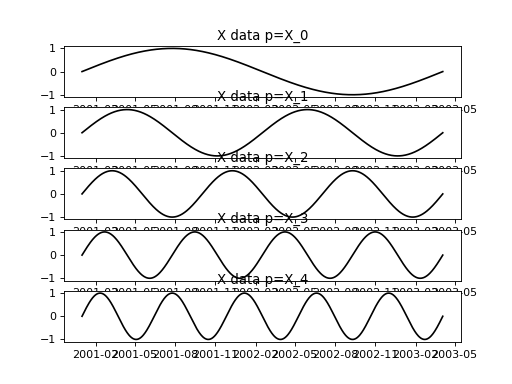

<IPython.core.display.Javascript object>


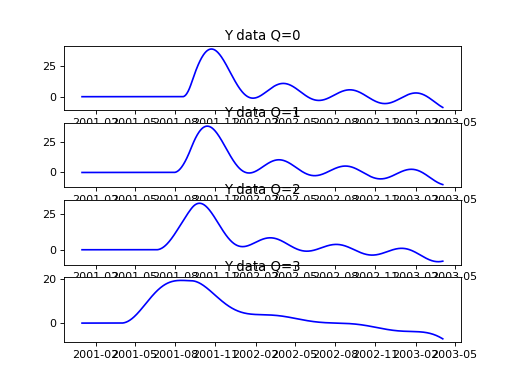

In [157]:
# convolution 1-D
#################################################
%matplotlib nbagg

from pylab import *
import pandas as pd
import tensorflow as tf
DTYPE = tf.float32

tf.reset_default_graph()
sess =  tf.InteractiveSession()

def causal_conv( X, h, padding='SAME' ):
    '''
    implement a causal convolution in tensorflow
    T - timepoints
    P - num features
    N - num observations  (e.g. tids)
    
    Parameters
    ----------
    X:  T x N x P tensor
    h:  k x P x Q tensor
    padding: SAME or VALID
        if SAME - output is SAME shape as input
        if VALID - output is T - 2*(k-1) x N x Q       
    
    Returns
    --------
    T x N x Q tensor    
    '''
    return tf.transpose(
        tf.nn.conv1d(  
            tf.transpose( X, (1, 0, 2) ),
            tf.concat( [h, tf.zeros_like(h)], axis=0, name='causal_filter'),
            stride=1, padding=padding
        ),
        (1,0,2)
    )

def unshape_df( df, cols,  groupby_key='tid', ):
    '''
    Convert a (time x tid) x cols dataframe into a T x N x P tensor
    T -> time
    N -> tids
    P -> input features
    '''    
    # unstack the dataframe on it's groupby keys
    usdf = df.set_index(groupby_key, append=True)[cols].unstack(level=1)
    T_index = usdf.index
    N_index = usdf.columns.levels[1]
    P_index = cols
    # convert this into a T x N x P array
    return (
        np.array( [usdf.loc[:, (slice(None), n)].values for n in N_index ] ).transpose( (1,0,2) ), 
        T_index, N_index, P_index
    )

def reshape_df( Y, T_index, N_index, Q_index, groupby_key='tid'):
    '''
    Convert a T x N x Q tensor into a  (time x tid) x cols dataframe
    T -> time
    N -> tids
    Q -> output features
    '''
    return pd.concat( [
        pd.DataFrame( 
            Ya[:,:, q], index=T_index, 
            columns=pd.MultiIndex.from_tuples( tuples=tuple([(Q_index[q], n) for n in N_index ]  ) ) 
        )  for q in range(len(Q_index )) ], 
        axis=0 
    ).stack(level=1).reset_index(level=1).rename( columns={'level_1':groupby_key})


# generate a syntehtic example
######################################    
T = 824
N = 512
P = 5
Q = 4
dfs = []
for tid in range( N ):
    df = pd.DataFrame( {'tid':str(tid)}, index=pd.date_range( start='20010101', periods=T,))
    for p in range(P):
        df['X_{}'.format(p)] = np.sin( linspace( 0, 2*pi*(p+1), T ) )
    dfs.append(df)
Xdf = pd.concat( dfs, axis=0).sort_index()

# define the convoluation model
h = tf.constant( np.array([ 
    np.concatenate( [ones( (10*2**(q+1), P) )/2**(q+1), zeros( (250-10*2**(q+1), P))], axis=0 ) for q in range(Q)    
]).transpose( (1,2,0) ), dtype=DTYPE )
X = tf.placeholder( shape=(None,None,P ), dtype=DTYPE )

Xa, T_index, N_index, P_index = unshape_df( Xdf, cols=['X_{}'.format(p) for p in range(P)] )
Ya = causal_conv( X, h ).eval( feed_dict={ X:Xa} )
Q_index=['Y_{}'.format(q) for q in range(Q)]
Ydf = reshape_df( Ya, T_index, N_index, Q_index)


print( 'h.shape=', h.shape, 'Xa.shape = ', Xa.shape,  'Ya.shape = ', Ya.shape  )
%matplotlib nbagg
for p in range(P):
    subplot( P, 1, p+1 )
    plot( Xdf[Xdf.tid=='1'][P_index[p]], '-k')        
    gca().set_title('X data p={}'.format(P_index[p]))
    
figure()
for q in range(Q):
    subplot( Q, 1, q+1 )
    gca().plot( Ydf[Ydf.tid=='1'][Q_index[q]], '-b')    
    gca().set_title('Y data Q={}'.format(q))
        
    


In [156]:
Xdf[Xdf.tid=='1']





,tid,X_0,X_1,X_2,X_3,X_4
2001-01-01,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-02,1,7.634416e-03,1.526839e-02,2.290147e-02,3.053321e-02,3.816318e-02
2001-01-03,1,1.526839e-02,3.053321e-02,4.579092e-02,6.103796e-02,7.627076e-02
2001-01-04,1,2.290147e-02,4.579092e-02,6.865636e-02,9.148578e-02,1.142672e-01
2001-01-05,1,3.053321e-02,6.103796e-02,9.148578e-02,1.218483e-01,1.520972e-01
2001-01-06,1,3.816318e-02,7.627076e-02,1.142672e-01,1.520972e-01,1.897056e-01
2001-01-07,1,4.579092e-02,9.148578e-02,1.369887e-01,1.822042e-01,2.270375e-01
2001-01-08,1,5.341600e-02,1.066795e-01,1.596383e-01,2.121414e-01,2.640387e-01
2001-01-09,1,6.103796e-02,1.218483e-01,1.822042e-01,2.418807e-01,3.006552e-01
2001-01-10,1,6.865636e-02,1.369887e-01,2.046746e-01,2.713945e-01,3.368337e-01


In [139]:


                          
    

    


def df_causal_conv( df, xcols, ycols, h, groupby_key='tid', padding='SAME'):
    '''
    apply a causal convolution on the input time-series panel dataframe
    
    Parameters
    ----------
    df: time-indexed panel dataframe 
    xcols: The P feature columns
    ycols: the Q output column names
    h: k X P X Q convolation kernel
    groupby_keys: The keys that groupby the panel dataset
    padding: See causal_conv documentation
    
    Returns:
    -------
    a dataframe with (T x tid) rows and Q columns    
    '''
    # place holder tensor
    Xt = tf.placeholder( shape=(None, None, P), dtype=DTYPE )
    # placeholder output tensor
    Yt = causal_conv( X, h )
    # T x N x Q output
    Ya = Yt.eval( feed_dict={X:Xa} )
    # covnert this into a ( time x tid ) x Q dataframe


MultiIndex(levels=[['op_3'], ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '2

In [145]:
Xdf


,tid,X_0,X_1,X_2,X_3,X_4
2001-01-01,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,62,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,410,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,409,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,63,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,408,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,407,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,64,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,406,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001-01-01,65,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [147]:



Ydf



,tid,conv_0,conv_1,conv_2,conv_3
2001-01-01,0,0.0,NaN,NaN,NaN
2001-01-01,1,0.0,NaN,NaN,NaN
2001-01-01,10,0.0,NaN,NaN,NaN
2001-01-01,100,0.0,NaN,NaN,NaN
2001-01-01,101,0.0,NaN,NaN,NaN
2001-01-01,102,0.0,NaN,NaN,NaN
2001-01-01,103,0.0,NaN,NaN,NaN
2001-01-01,104,0.0,NaN,NaN,NaN
2001-01-01,105,0.0,NaN,NaN,NaN
2001-01-01,106,0.0,NaN,NaN,NaN


In [44]:
X.shape













(512, 824, 12)